# TP 2 - Procesamiento del Lenguaje Natural

## Librerias y Funciones


In [42]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix
from mlxtend.preprocessing import DenseTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect, detect_langs
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.layers import Dense, Input, Dropout
from nltk.tokenize.toktok import ToktokTokenizer
#from emoji import emoji_count, demojize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import os

In [2]:
def mostrar_scores(y_test: np.ndarray, y_prediccion: np.ndarray):
    accuracy = accuracy_score(y_test,y_prediccion)
    recall = recall_score(y_test,y_prediccion)
    f1 = f1_score(y_test,y_prediccion,)
    precision = precision_score(y_test,y_prediccion)

    print("Accuracy: "+str(accuracy))
    print("Recall: "+str(recall))
    print("Precision: "+str(precision))
    print("f1 score: "+str(f1))

def cantidad_de_palabras(review):
    return len(review.split())

## Analisis Exploratorio

Comenzamos con el analisis exploratorio de los datos, para ello vamos a cargar los datos y a ver como estan distribuidos.

In [4]:
df = pd.read_csv('train.csv', sep=',')
df.head(10)

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo
5,5,Probablemente mi película favorita de todos lo...,positivo
6,6,Seguro que me gustaría ver una resurrección de...,positivo
7,7,"Este espectáculo fue una idea increíble, fresc...",negativo
8,8,Alentados por los comentarios positivos sobre ...,negativo
9,9,"Si te gusta la risa original desgarradora, te ...",positivo


Podemos observar que contamos con un total de 50000 reviews

In [5]:
df.shape

(50000, 3)

Como se puede observar en el siguiente grafico, veremos que la distribucion con mitad de reviews positivas y mitad de reviews negativas.

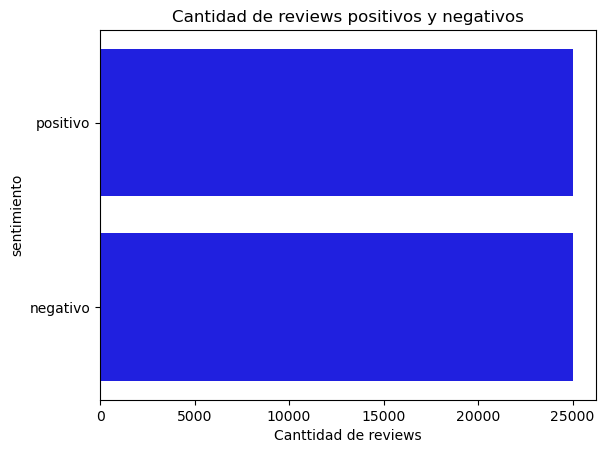

In [6]:
sns.countplot(df['sentimiento'], color='blue')
plt.xlabel('Canttidad de reviews')
plt.title('Cantidad de reviews positivos y negativos')
plt.show()

A continuacion vamos a adentrarnos a analizar las caracteristicas de las reviews en general.

En primer lugar vamos a analizar el dataset para ver si contiene emojis

In [7]:
df['tiene_emoji'] = df['review_es'].apply(emoji_count)
cantidad_emojis = df['tiene_emoji'].value_counts().reset_index()
cantidad_emojis.columns = ['cantidad_emojis', 'cantidad_filas']
cantidad_emojis

NameError: name 'emoji_count' is not defined

Por otro lado, buscaremos saber como se distribuye la longitud de las reviews. Para ello, vamos a calcular la cantidad de palabras de cada review.

In [8]:
df['cantidad_de_palabras'] = df['review_es'].apply(cantidad_de_palabras)

In [9]:
df['cantidad_de_palabras'].describe()

count    50000.000000
mean       237.233680
std        179.529306
min          6.000000
25%        123.000000
50%        172.000000
75%        293.000000
max       2450.000000
Name: cantidad_de_palabras, dtype: float64

Ahora realizaremos un analisis grafico de la cantidad de palabras para ver si encontramos ciertas tendencias.

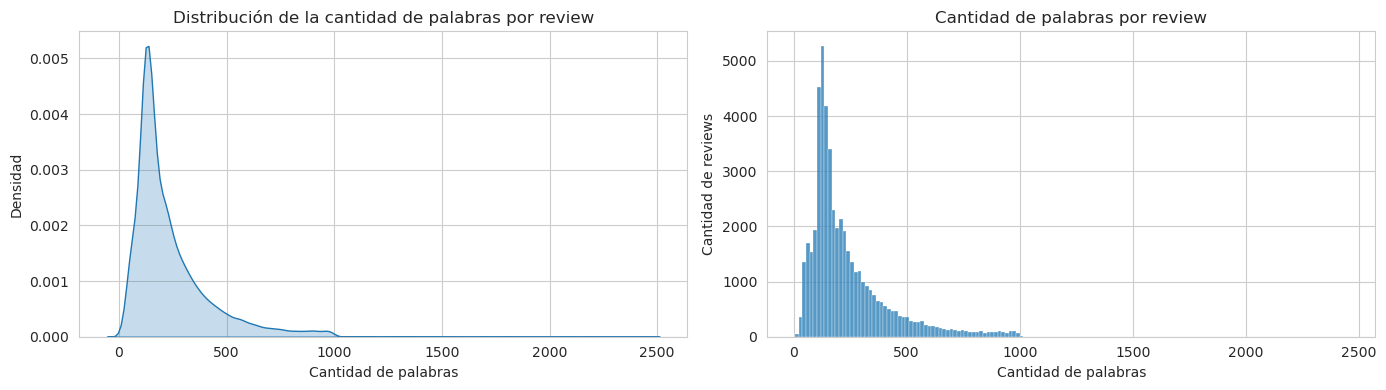

In [10]:
sns.set_style('whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.kdeplot(df['cantidad_de_palabras'], fill=True, ax=ax1).set_title('Distribución de la cantidad de palabras por review')
ax1.set_ylabel('Densidad')
ax1.set_xlabel('Cantidad de palabras')

sns.histplot(df['cantidad_de_palabras'],  ax=ax2, bins=150, kde=False).set_title('Distribución de la cantidad de palabras por review')
ax2.set_xlabel('Cantidad de palabras')
ax2.set_ylabel('Cantidad de reviews')

plt.title('Cantidad de palabras por review')
plt.tight_layout()
plt.show()

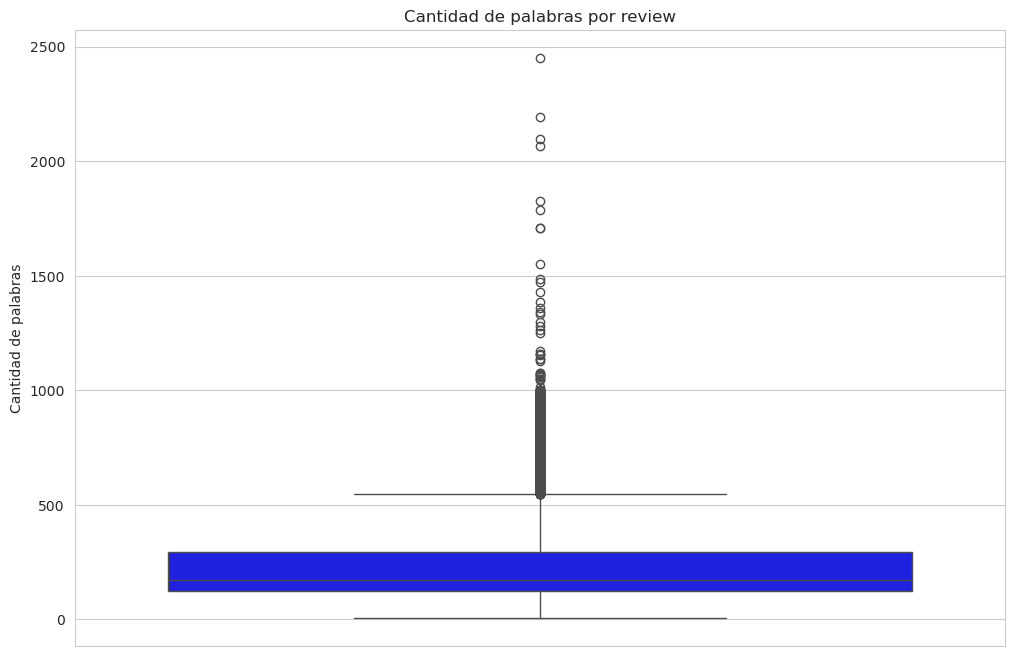

In [11]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.boxplot(df['cantidad_de_palabras'], color='blue')
plt.ylabel('Cantidad de palabras')
plt.title('Cantidad de palabras por review')
plt.show()

Como se puede observar en el boxplot de arriba, contamos con bastantes outliers en la cantidad de palabras de las reviews. Por lo tanto, vamos a utilizar otras tecnicas como el z-score y z-score modificado para ver cuantas reviews serian consideradas outliers.

In [12]:
df['zscore'] = (df['cantidad_de_palabras'] - df['cantidad_de_palabras'].mean()) / df['cantidad_de_palabras'].std()

In [13]:
df_z_score = df[(df['zscore'] > 3) | (df['zscore'] < -3)]
df_z_score.shape

(1240, 5)

In [14]:
mediana_cantidad_de_palabras=np.median(df['cantidad_de_palabras'])
MAD=np.median(np.absolute(df['cantidad_de_palabras']-mediana_cantidad_de_palabras))

df['zm_cantidad_de_palabras']=(df['cantidad_de_palabras'] - mediana_cantidad_de_palabras)*0.6745/MAD
df[np.absolute(df['zm_cantidad_de_palabras'] > 3.5)].shape

(4320, 6)

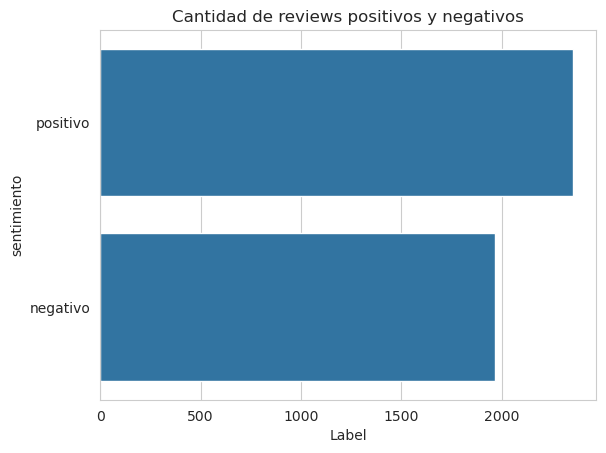

In [15]:
sns.countplot(df[np.absolute(df['zm_cantidad_de_palabras'] > 3.5)]['sentimiento'])
plt.xlabel('Label')
plt.title('Cantidad de reviews positivos y negativos')
plt.show()

Por otro lado, creimos que tambien seria interesante ver como se distribuye la cantidad de palabras de las reviews en funcion de su sentimiento.

/tmp/ipykernel_85393/2888992444.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentimiento', y='cantidad_de_palabras', data=df, palette='rainbow')


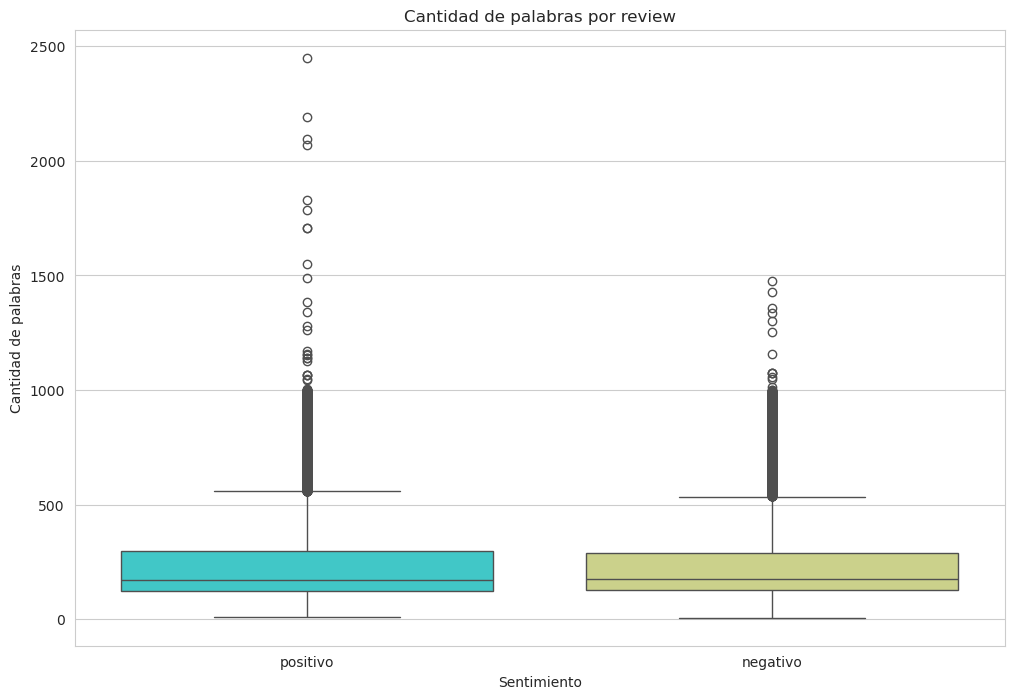

In [16]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.boxplot(x='sentimiento', y='cantidad_de_palabras', data=df, palette='rainbow')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de palabras')
plt.title('Cantidad de palabras por review')
plt.show()

Ademas, otro factor que creemos que puede ser importante es la cantidad de caracteres de las reviews. Por lo tanto, vamos a calcular la cantidad de caracteres de cada review. Esta informacion nos servira luego a la hora de traducir los reviews ya que la API de Google Translate tiene un limite de caracteres por request de 5000 caracteres.

In [17]:
df['longitud_review'] = df['review_es'].apply(lambda x: len(str(x)))
df['longitud_review'].describe()

count    50000.000000
mean      1398.058240
std       1037.688582
min         39.000000
25%        747.000000
50%       1037.000000
75%       1711.000000
max      13465.000000
Name: longitud_review, dtype: float64

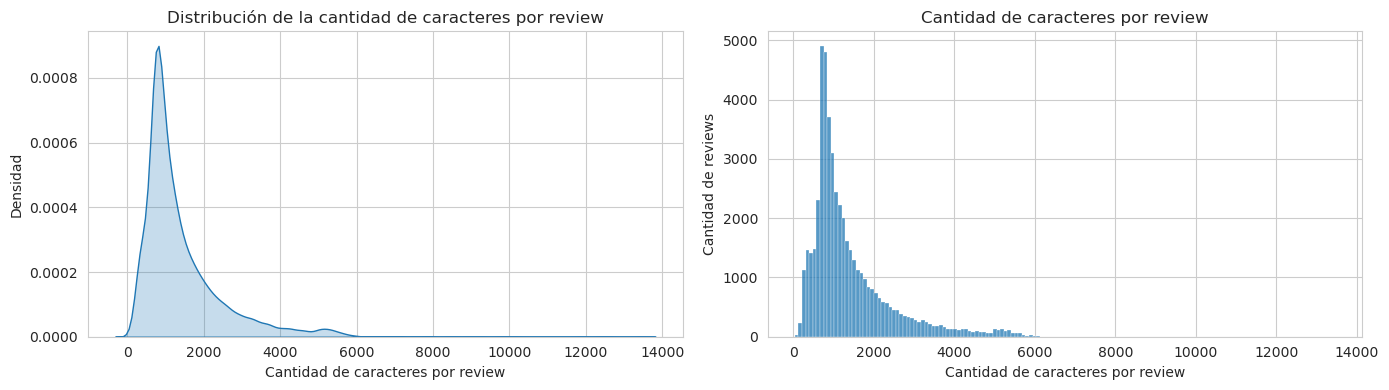

In [18]:
sns.set_style('whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.kdeplot(df['longitud_review'], fill=True, ax=ax1).set_title('Distribución de la cantidad de caracteres por review')
ax1.set_ylabel('Densidad')
ax1.set_xlabel('Cantidad de caracteres por review')

sns.histplot(df['longitud_review'],  ax=ax2, bins=150, kde=False).set_title('Cantidad de caracteres por review')
ax2.set_xlabel('Cantidad de caracteres por review')
ax2.set_ylabel('Cantidad de reviews')

plt.tight_layout()
plt.show()

Luego, verificamos que no haya reviews duplicadas. En caso positivo, durante el preprocesamiento las eliminaremos.

In [19]:
df['review_es'].duplicated().sum()

401

Otro analisis importante que esten en otro idioma ya que distorsionarian fuertemente el analisis. En caso positivo, durante el preprocesamiento las intentaremos traducir al castellano. La otra opcion seria eliminarlas, veremos cual nos brinda mejores resultados.

In [20]:
if os.path.isfile('train_con_idioma.csv'):
    df = pd.read_csv('train_con_idioma.csv', sep=',')
else:
    df['idioma'] = df['review_es'].apply(detect)
    df['idioma'].value_counts()

In [21]:
if not os.path.isfile('train_con_idioma.csv'):
    df.to_csv('train_con_idioma.csv', index=False)

Por ultimo, vamos a verificar la cantidad total de palabras unicas en nuestro dataset.

In [22]:
tokens = []
for review in df['review_es']:
    tokens.extend(review.split())

palabras_unicas = set(tokens)
numero_de_palabras_unicas = len(palabras_unicas)

print("Numero de palabras unicas en el dataset pre preprocesamiento:", numero_de_palabras_unicas)

Numero de palabras unicas en el dataset pre preprocesamiento: 559112


## Preprocesamiento

Comenzamos eliminando los duplicados identificados anteriormente ya que no nos aportan informacion adicional.

In [23]:
df = df.drop_duplicates(subset=['review_es'])
df.shape

(49599, 8)

Elegimos eliminar las reviews que no esten en castellano ya que con la traduccion nuestros modelos empeoraban su performance.

In [24]:
df = df[df['idioma'].isin(['es'])]
df['idioma'].value_counts()

idioma
es    47782
Name: count, dtype: int64

Como pudimos ver anteriormente, existen unas reviews las cuales contienen emojis pero a pesar de que sean muy pocos igualmente vamos a convertirlos a texto.

In [25]:
df['review_es'] = df['review_es'].apply(demojize)

NameError: name 'demojize' is not defined

In [ ]:
df['tiene_emoji'] = df['review_es'].apply(emoji_count)
cantidad_emojis = df['tiene_emoji'].value_counts().reset_index()
cantidad_emojis.columns = ['cantidad_emojis', 'cantidad_filas']
cantidad_emojis

/var/folders/pm/lyty8ft16l3dvy_kdh07l4dc0000gn/T/ipykernel_79381/3651782182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tiene_emoji'] = df['review_es'].apply(emoji_count)


,cantidad_emojis,cantidad_filas
0,0,47783


Teniendo los emojis convertidos a texto podemos continuar trabajando con el dataset

A continuacion, vamos a eliminar todas las reviews que tengan el z-score modificado mayor a 3.5 en modulo. Decidimos tener mas en cuenta este metodo ya que creemos que es mas efectivo que el z-score normal debido a que los outliers distorsionan notablemente esta metrica.

In [26]:
df = df[np.absolute(df['zm_cantidad_de_palabras'] <= 3.5)]
df.shape

(44142, 8)

Con esto, eliminamos casi un 10% de samples del dataset original, entre los duplicados, las reviews que no estaban en castellano y las que tenian un z-score modificado mayor a 3.5 en modulo.

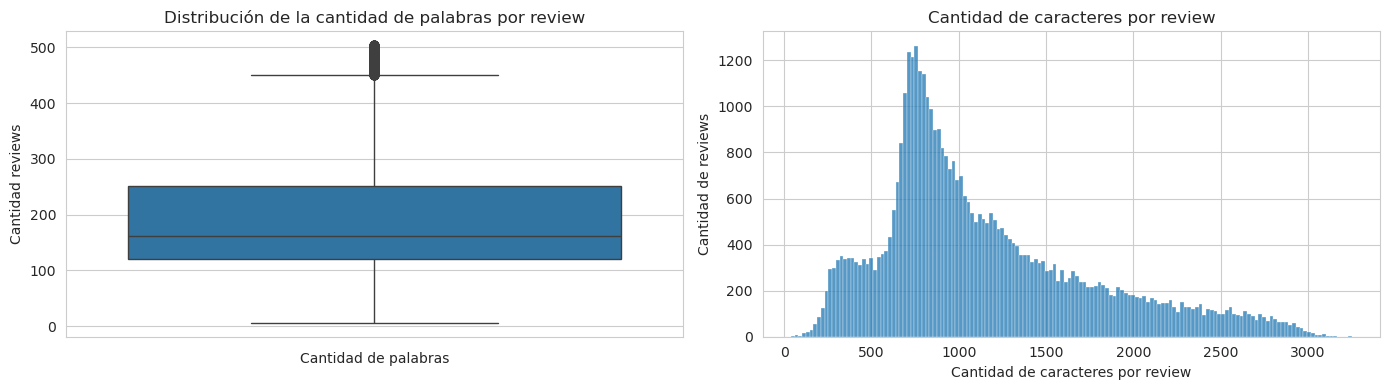

In [27]:
sns.set_style('whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.boxplot(df['cantidad_de_palabras'], fill=True, ax=ax1).set_title('Distribución de la cantidad de palabras por review')
ax1.set_ylabel('Cantidad reviews')
ax1.set_xlabel('Cantidad de palabras')

sns.histplot(df['longitud_review'],  ax=ax2, bins=150, kde=False).set_title('Cantidad de caracteres por review')
ax2.set_xlabel('Cantidad de caracteres por review')
ax2.set_ylabel('Cantidad de reviews')

plt.tight_layout()
plt.show()

/tmp/ipykernel_85393/3171170284.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentimiento', y='cantidad_de_palabras', data=df, palette='rainbow')


Text(0.5, 1.0, 'Cantidad de palabras por review')

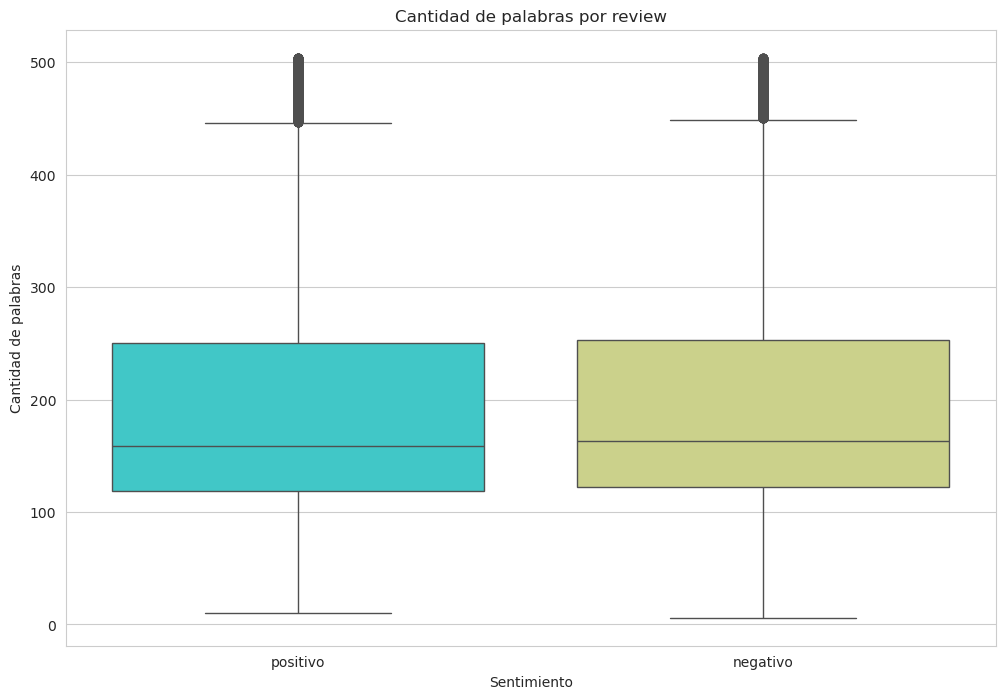

In [28]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.boxplot(x='sentimiento', y='cantidad_de_palabras', data=df, palette='rainbow')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de palabras')
plt.title('Cantidad de palabras por review')

Ademas, vamos a analizar que luego de la eliminacion de estos reviews nos quede una distribucion parecida de samples positivos y negativos.

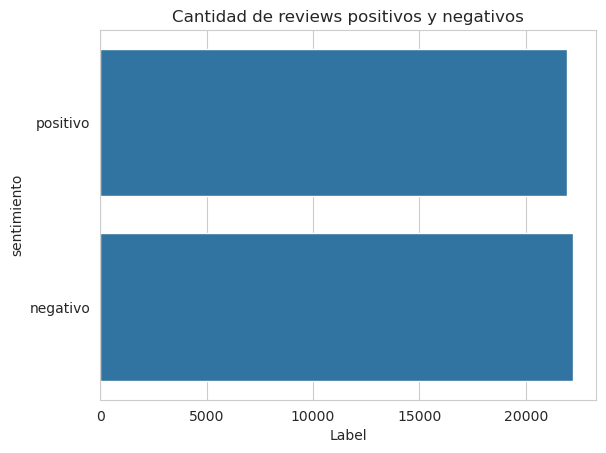

In [29]:
sns.countplot(df['sentimiento'])
plt.xlabel('Label')
plt.title('Cantidad de reviews positivos y negativos')
plt.show()

La cantidad sigue siendo bastante pareja, por lo tanto, podemos continuar con el preprocesamiento.

Como habiamos mencionado anteriormente, vamos a traducir las reviews que no esten en castellano. Para ello, vamos a utilizar la API de Google Translate. 

In [ ]:
from deep_translator import GoogleTranslator

def traducir_al_castellano(texto, idioma):
    traduccion = GoogleTranslator(source='english', target='spanish').translate(texto)
    return traduccion

if not os.path.isfile('datasets/train_con_traduccion.csv'):
    for index, row in df.iterrows():
        if row['idioma'] == 'en':
            df.loc[index, 'review_es'] = traducir_al_castellano(row['review_es'],'en' )
else:
    df = pd.read_csv('train_con_traduccion.csv', sep=',')

A continuacion realizaremos un paso muy importante en este tp, el cual va a reducir el tiempo de entrenaminto de los modelos, va a mejorar su performance y va a evitar que los modelos se sobreajusten. Este paso es el preprocesamiento de las reviews.

Los pasos a realizar son los siguientes:

- limpiar texto = Elimina los caracteres que no sean un caracter alfanumerico y los reemplaza por espacios en blanco. Elimina las palabras que tienen solo un carácter alfabético y las reemplaza por espacios en blanco. Sustituye múltiples espacios en blanco por uno solo. Convierte todos los caracteres del texto a minúsculas.

- filtrar stopwords = elimina las stopwords que son palabras comunes sin significado específico.

- stem palabras = reduce cada token a su raíz (o "stem").

- tokenize = realiza una serie de operaciones de preprocesamiento y devuelve el texto tokenizado y procesado.

In [31]:
df_preprocesado = df.copy()

tokenizer = ToktokTokenizer() 
STOPWORDS = set(stopwords.words("spanish"))
stemmer = nltk.stem.SnowballStemmer("spanish")

def limpiar_texto(texto):
    # Eliminamos los caracteres especiales
    texto = re.sub(r'\W', ' ', str(texto))
    # Eliminado las palabras que tengo un solo caracter
    texto = re.sub(r'\s+[a-zA-Z]\s+', ' ', texto)
    # Sustituir los espacios en blanco en uno solo
    texto = re.sub(r'\s+', ' ', texto, flags=re.I)
    # Convertimos textos a minusculas
    texto = texto.lower()
    return texto

# def filtrar_stopword_digitos(tokens):
#     return [token for token in tokens if token not in STOPWORDS 
#             and not token.isdigit()]

def filtrar_stopword(tokens):
     return [token for token in tokens if token not in STOPWORDS]

def stem_palabras(tokens):
    return [stemmer.stem(token) for token in tokens]

def tokenize(texto):
    text_cleaned = limpiar_texto(texto)
    tokens = [word for word in tokenizer.tokenize(text_cleaned) if len(word) > 1]
    tokens = filtrar_stopword(tokens)
    stems = stem_palabras(tokens)
    stems = ' '.join(stems)
    return stems

In [32]:
df_preprocesado['review_es'] = df_preprocesado['review_es'].apply(tokenize)

In [33]:
if not os.path.isfile('datasets/train_preprocesado_sin_traduccion.csv'):
    df_preprocesado.to_csv('train_preprocesado_sin_traduccion.csv', index=False)

In [3]:
df_preprocesado = pd.read_csv('train_preprocesado_sin_traduccion.csv', sep=',')

Con esto podemos observar brevemente como quedan las reviews luego de este preprocesamiento.

In [4]:
df_preprocesado.head(10)

,ID,review_es,sentimiento,cantidad_de_palabras,zscore,zm_cantidad_de_palabras,longitud_review,idioma
0,0,critic mencion despues ver sol oz episodi enga...,positivo,345,0.600271,1.823258,2004,es
1,1,pequeñ pequeñ produccion tecnic filmacion incu...,positivo,161,-0.424631,-0.115930,1061,es
2,2,pens maner maravill pas tiemp fin seman veran ...,positivo,173,-0.357789,0.010539,989,es
3,3,basic famili niñ pequeñ jak piens zombi armari...,negativo,137,-0.558314,-0.368867,790,es
4,4,amor tiemp pett mattei pelicul visual impresio...,positivo,237,-0.001302,0.685039,1406,es
5,5,probabl pelicul favorit tiemp histori desinter...,positivo,123,-0.636295,-0.516414,724,es
6,6,segur gust ver resurreccion seri seahunt dat t...,positivo,157,-0.446911,-0.158086,839,es
7,7,espectacul ide increibl fresc innov años 70 em...,negativo,168,-0.385640,-0.042156,1034,es
8,8,alent comentari posit pelicul aqu des ver peli...,negativo,120,-0.653006,-0.548031,708,es
9,9,si gust ris original desgarr gust pelicul si j...,positivo,31,-1.148747,-1.486008,186,es


In [36]:
tokens = []
for review in df_preprocesado['review_es']:
    tokens.extend(review.split())

palabras_unicas = set(tokens)
numero_de_palabras_unicas = len(palabras_unicas)

print("Numero de palabras unicas en el dataset post preprocesamiento:", numero_de_palabras_unicas)

Numero de palabras unicas en el dataset post preprocesamiento: 78654


Se puede observar que el preprocesamiento disminuyo notablemente nuestro bag of words.

Como ultimo paso del preprocesamiento, dividimos el dataset en train y test. Utilizamos un ratio de 80% para train y 20% para test. Ademas, utilizamos el parametro random_state para que la division sea reproducible. Tambien trasladamos los labels a valores numericos para poder trabajar con ellos.

In [24]:
df_preprocesado['sentimiento'] = df_preprocesado['sentimiento'].map({'negativo': 0, 'positivo': 1, 0: 0, 1: 1})

x_train, x_test, y_train, y_test = train_test_split(df_preprocesado['review_es'], df_preprocesado['sentimiento'], test_size=0.2, random_state=42)

## Entrenamiento de modelos

Cabe recalcar que para cada modelo utilizamos CounVectorizer y TfidfVectorizer para ver cual nos brindaba mejores resultados. Solo mantenemos el que mejor performance nos brindo. Ademas, utilizamos RandomizedSearchCV para encontrar los mejores hiperparametros para los modelos principales.

### Modelos de Bayes Naïve

#### Bayes Naïve Multinomial

##### Vamos a probar en primer lugar con un count vectorizer y luego con un tfidf vectorizer par ver con cual obtenemos merjores resultados

In [20]:
modelo_count = make_pipeline(CountVectorizer(), MultinomialNB())
modelo_tfidf = Pipeline([('tvec', TfidfVectorizer()), ('mnb',MultinomialNB())])

In [25]:
modelo_count.fit(x_train, y_train)
prediccion_count = modelo_count.predict(x_test)

mostrar_scores(y_test, prediccion_count)

Accuracy: 0.8492468003171367
Recall: 0.8321550741163056
Precision: 0.8598020735155514
f1 score: 0.845752694402596


In [40]:
modelo_tfidf.fit(x_train, y_train)
prediccion_tfidf = modelo_tfidf.predict(x_test)

mostrar_scores(y_test, prediccion_tfidf)

Accuracy: 0.8436969079170914
Recall: 0.8120866590649943
Precision: 0.8649502064610153
f1 score: 0.8376852505292872


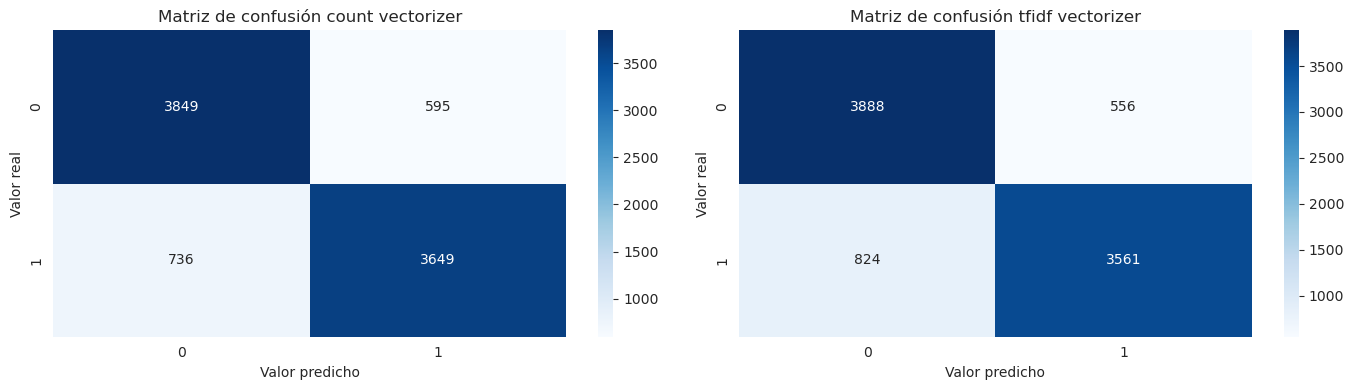

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

matriz_confusion = confusion_matrix(y_test, prediccion_count)
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', ax=ax1).set_title('Matriz de confusión count vectorizer')
ax1.set_xlabel('Valor predicho')
ax1.set_ylabel('Valor real')

matriz_confusion = confusion_matrix(y_test, prediccion_tfidf)
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', ax=ax2).set_title('Matriz de confusión tfidf vectorizer')
ax2.set_xlabel('Valor predicho')
ax2.set_ylabel('Valor real')

plt.tight_layout()
plt.show()

Podemos ver que en que en ambos casos nuestro modelo tiende a predecir a una review como negativa. Es por esto que la metrica de recall se ve tan baja comparada a la precision.

In [42]:
prediccion_count_train = modelo_count.predict(x_train)
prediccion_tfidf_train = modelo_tfidf.predict(x_train)

print("Prediccion en train con count vectorizer")
mostrar_scores(y_train, prediccion_count_train)
print("----------------------------------------")
print("Prediccion en train con tfidf vectorizer")
mostrar_scores(y_train, prediccion_tfidf_train)

Prediccion en train con count vectorizer
Accuracy: 0.9045960411180018
Recall: 0.8874715261958998
Precision: 0.9179478117453025
f1 score: 0.9024524423082492
----------------------------------------
Prediccion en train con tfidf vectorizer
Accuracy: 0.8978846317220287
Recall: 0.8745444191343964
Precision: 0.9162887828162292
f1 score: 0.8949300699300698


Notamos que en ambos casos, nuestro modelo esta overfitteado.

Vamos a resolver este limitando la cantidad de features que utiliza el modelo. Para ello, vamos a utilizar el parametro max_features del vectorizer. De ahora en mas continuaremos solo con el count vectorizer ya que obtuvimos mejores resultados con el.

In [43]:
vectorizer = CountVectorizer(max_features=6000)
modelo_tfidf = make_pipeline(vectorizer, MultinomialNB(alpha=0.1))
modelo_tfidf.fit(x_train, y_train)

prediccion = modelo_tfidf.predict(x_test)

mostrar_scores(y_test, prediccion)

Accuracy: 0.8432438554762713
Recall: 0.8389965792474344
Precision: 0.8443883406013312
f1 score: 0.8416838252116221


In [44]:
prediccion_train = modelo_tfidf.predict(x_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.858550675388667
Recall: 0.8559794988610478
Precision: 0.8590615534091559
f1 score: 0.857517756796075


Con esto, podemos ver que nuestro modelo mantuvo su performance. Ademas, podemos ver que ya no esta overfitteado.

#### Bayes Naive con bigramas

Ahora vamos a probar una variante interesante la cual consiste en usar unigramas y bigramas y trigramas. Para ello, vamos a utilizar el parametro ngram_range del vectorizer. 

In [6]:
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=6000)
modelo_bigramas = make_pipeline(vectorizer, MultinomialNB(alpha=0.1))
modelo_bigramas.fit(x_train, y_train)

prediccion = modelo_bigramas.predict(x_test)

mostrar_scores(y_test, prediccion)

Accuracy: 0.8516253256314419
Recall: 0.85769669327252
Precision: 0.8457387002473578
f1 score: 0.8516757246376812


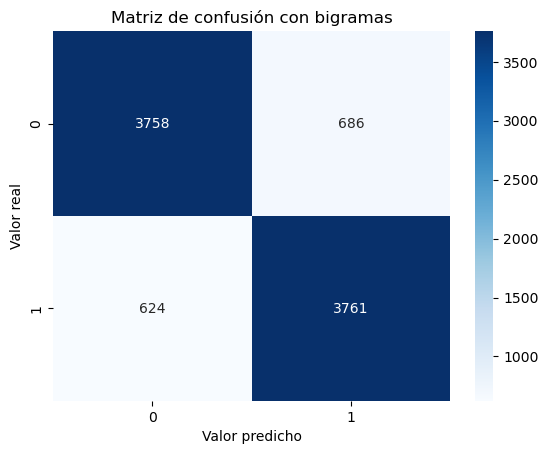

In [8]:
matriz_confusion = confusion_matrix(y_test, prediccion)
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues').set_title('Matriz de confusión con bigramas')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')
plt.show()

In [7]:
prediccion_train = modelo_bigramas.predict(x_train)

mostrar_scores(y_train, prediccion_train)


Accuracy: 0.8644408574745844
Recall: 0.8773348519362186
Precision: 0.8540384721991241
f1 score: 0.8655299306160286


Notamos una gran mejoria en la metrica de recall, lo cual es muy bueno ya que nuestro modelo ahora esta prediciendo mejor las reviews negativas. Sin embargo, la metrica de precision disminuyo un poco. El lado positivo es que nuestro modelo sigue sin estar overfitteado.

#### Bayes Naive Gausseano

In [5]:
vectorizer = TfidfVectorizer(max_features=2000)
modelo_gauss = make_pipeline(vectorizer, DenseTransformer(), GaussianNB())
modelo_gauss.fit(x_train, y_train)

prediccion = modelo_gauss.predict(x_test)

mostrar_scores(y_test, prediccion)

Accuracy: 0.7875184052554083
Recall: 0.7863169897377423
Precision: 0.7859585137907454
f1 score: 0.786137710898313


In [6]:
prediccion_train = modelo_gauss.predict(x_train)

mostrar_scores(y_train, prediccion_train)

: 

Notamos que los resultados de este tipo de modelo son muy pobres comparado a los anteriores. Es por ello que no vamos probarlo en profundidad.

#### Bayes Naive Bernoulli

In [10]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
modelo_bernoulli = make_pipeline(vectorizer, BernoulliNB(
))
modelo_bernoulli.fit(x_train, y_train)

prediccion = modelo_bernoulli.predict(x_test)

mostrar_scores(y_test, prediccion)

Accuracy: 0.8567221655906672
Recall: 0.8814139110604333
Precision: 0.8383947939262473
f1 score: 0.8593663146192329


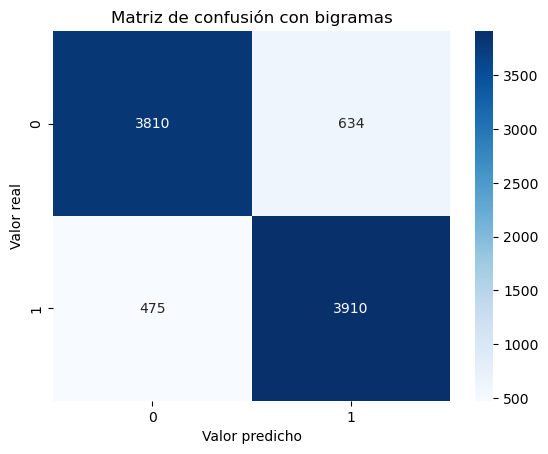

In [9]:
matriz_confusion = confusion_matrix(y_test, prediccion)
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues').set_title('Matriz de confusión con bigramas')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')
plt.show()

In [11]:
prediccion_train = modelo_bernoulli.predict(x_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.8732761306034604
Recall: 0.9013667425968109
Precision: 0.852296591459803
f1 score: 0.8761451385237053


Aqui podemos observar otro gran modelo a tener en cuenta ya que obtuvimos muy buenos resultados. El aspecto positivo de estos modelos de Bayes Naive es que son muy rapidos de entrenar y de predecir.

#### Busqueda de hiperparametros

In [ ]:
#randomized search cv para bayes naive bernoulli
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df_preprocesado['review_es'])
y = df_preprocesado['sentimiento'].map({'negativo': 0, 'positivo': 1, 0: 0, 1: 1})

modelo_bernoulli_BN = BernoulliNB()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

n_iter = 25
param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
                'fit_prior': [True, False]}
random_search = RandomizedSearchCV(modelo_bernoulli_BN, param_grid, n_iter=n_iter, cv=cv, scoring='f1', n_jobs=-1, verbose=3, random_state=42)
random_search.fit(X, y)

In [ ]:
print("Mejor estimador: ")
print(random_search.best_estimator_)
print("Mejor score: ")
print(random_search.best_score_)
print("Mejores parametros: ")
print(random_search.best_params_)

#### Predicción en los datos de test para kaggle

In [ ]:
df_test = pd.read_csv('test.csv', sep=',')
df_test_procesado = df_test.copy()

df_test_procesado['review_es'] = df_test_procesado['review_es'].apply(demojize)
df_test_procesado['review_es'] = df_test_procesado['review_es'].apply(tokenize)

prediccion = modelo_tfidf.predict(df_test_procesado['review_es'])

prediccion = np.where(prediccion == 0, 'negativo', 'positivo')

df_entrega = df_test.copy()


df_entrega['sentimiento'] = prediccion
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('entrega.csv', index=False)

### Regresión Logística

Realizaremos una regresion logistica ya que si bien el enunciado no lo pide, leimos que tiene una performance muy buena para este tipo de problemas.

In [33]:
modelo_regresion_logistica = Pipeline([('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1, 2))), ('lr', LogisticRegression(
    penalty='l2',
    C=0.3,
    solver='liblinear',
    max_iter=100, 
    l1_ratio=None, 
    tol=1e-4 
))])
modelo_regresion_logistica.fit(x_train, y_train)

prediccion = modelo_regresion_logistica.predict(x_test)

mostrar_scores(y_test, prediccion)

Accuracy: 0.8891154151092989
Recall: 0.8944127708095782
Precision: 0.8837314105452907
f1 score: 0.8890400090672107


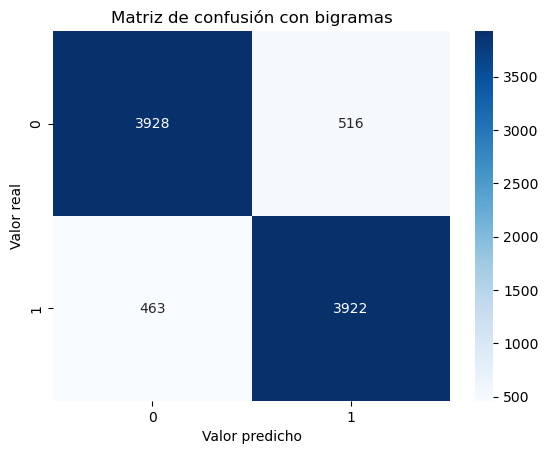

In [34]:
matriz_confusion = confusion_matrix(y_test, prediccion)
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues').set_title('Matriz de confusión con bigramas')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')
plt.show()

In [35]:
prediccion_train = modelo_regresion_logistica.predict(x_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.9505847704811259
Recall: 0.9542710706150341
Precision: 0.9467766540482513
f1 score: 0.9505090898777616


#### Busqueda de hiperparametros

In [31]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df_preprocesado['review_es'])
y = df_preprocesado['sentimiento'].map({'negativo': 0, 'positivo': 1, 0: 0, 1: 1})

modelo_regresion_logistica = LogisticRegression()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l2']
space['C'] = [0.01, 0.1, 0.3, 0.5, 1.0, 3]
space['l1_ratio'] = [None]
space['max_iter'] = [50, 100, 200, 300]

n_iter = 100
search = RandomizedSearchCV(modelo_regresion_logistica, space, n_iter=5, scoring='f1', n_jobs=-1, cv=cv, random_state=42)
result = search.fit(X, y)

In [32]:
print('Mejor Score: %s' % result.best_score_)
print('Mejores hiperparametros: %s' % result.best_params_)

promedios = result.cv_results_['mean_test_score']
params = result.cv_results_['params']
for promedio, param in zip(promedios, params):
    print(">%.3f with: %r" % (promedio, param))

Mejor Score: 0.8839520777881859
Mejores hiperparametros: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 50, 'l1_ratio': None, 'C': 3}
>0.847 with: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 100, 'l1_ratio': None, 'C': 0.01}
>0.884 with: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 50, 'l1_ratio': None, 'C': 3}
>0.867 with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 200, 'l1_ratio': None, 'C': 0.1}
>0.847 with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 50, 'l1_ratio': None, 'C': 0.01}
>0.876 with: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 100, 'l1_ratio': None, 'C': 0.3}


#### Predicción en los datos de test para kaggle

In [ ]:
df_test = pd.read_csv('test.csv', sep=',')
df_test_copia = df_test.copy()

df_test_copia['review_es'] = df_test_copia['review_es'].apply(demojize)
df_test_copia['review_es'] = df_test_copia['review_es'].apply(tokenize)

prediccion = modelo_regresion_logistica.predict(df_test_copia['review_es'])
prediccion = np.where(prediccion == 0, 'negativo', 'positivo')

df_entrega = df_test.copy()

df_entrega['sentimiento'] = prediccion
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('lr_preproceso_demoji.csv', index=False)

### XGBoost

Seguiremos con un modelo de XGBoost ya que es un modelo que esperamos que va a tener muy buenos resultados.

In [ ]:
modelo_xg_boost = Pipeline([
  ('tfidf', TfidfVectorizer(max_features=9000, ngram_range=(1, 2))), 
  ('xgb', XGBClassifier(
        objective='binary:logistic',
        n_jobs=-1,
        random_state=42,
        colsample_bytree=0.6, 
        subsample=0.6,
        gamma=0.3, 
        max_depth=5,
        learning_rate=0.089, 
        min_child_weight=10, 
        n_estimators=700, 
))])

modelo_xg_boost.fit(x_train, y_train)

y_pred = modelo_xg_boost.predict(x_test)

mostar_scores(y_test, y_pred)

In [ ]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, annot=True, fmt='d')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [ ]:
y_pred_train = modelo_xg_boost.predict(x_train)

mostar_scores(y_train, y_pred_train)

#### Busqueda de hiperparametros

In [40]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df_preprocesado['review_es'])
y = df_preprocesado['sentimiento'].map({'negativo': 0, 'positivo': 1, 0: 0, 1: 1})

modelo_xg_boost = XGBClassifier(
    objective='binary:logistic',
    n_jobs=-1,
    random_state=42
)

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.1,  0.3,  0.5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'learning_rate': list(np.linspace(0.001, 0.1, 10)),
        'n_estimators': [ 300, 400, 500, 600, 700, 800, 900, 1000],
        }

folds = 5
n_iter = 100
cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(modelo_xg_boost, param_distributions=params, n_iter=n_iter, scoring='f1', n_jobs=-1, cv=cv, random_state=42 )
random_search.fit(X, y)

/home/mateov/programas/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/mateov/programas/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/mateov/programas/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/mateov/programas/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/mateov/programas/anaconda3/lib/python3.11/site-pac

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importan...
                   n_iter=1, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.1, 0.3, 0.5],
                                        'learning_rate': [0.001, 0.012,
                                                          0.023000000000000003,
                                                          0.034,
                                                          0.045000000000000005,
                                                          0.05600000000000001,
                                                          0.067,
                                                          0.07800000000000001,
                                                          0.08900000000000001,
                                                          0.1],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [300, 400, 500, 600],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='f1')

In [41]:
print('\n Mejor estimador:')
print(random_search.best_estimator_)
print('\n Mejor hiperparm:')
print(random_search.best_score_)


 Mejor estimador:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08900000000000001,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

 Mejor hiperparm:
0.8642347928007048


#### Predicción en los datos de test para kaggle

In [ ]:
df_test = pd.read_csv('test.csv', sep=',')
df_test_copia = df_test.copy()

df_test_copia['review_es'] = df_test_copia['review_es'].apply(demojize)
df_test_copia['review_es'] = df_test_copia['review_es'].apply(tokenize)


prediccion = modelo_xg_boost.predict(df_test_copia['review_es'])
prediccion = np.where(prediccion == 0, 'negativo', 'positivo')

df_entrega = df_test.copy()

df_entrega['sentimiento'] = prediccion
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('entrega.csv', index=False)

### Random Forest

Otro modelo que utilizaremos es el de Random Forest ya que es un modelo que esperamos que va a tener buenos resultados. Sin embargo, creemos que no va a superar a XGBoost. La ventaja de este modelo es que es muy rapido de entrenar y de predecir.

In [ ]:
modelo_random_forest = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=7000, ngram_range=(1, 2))), 
    ('rfc', RandomForestClassifier(
            criterion='entropy',
            n_jobs=-1,
            random_state=42,
            max_depth=20,
            min_samples_leaf=50,
            n_estimators=1000,
    ))])

modelo_random_forest.fit(X_train, y_train)

y_pred = modelo_random_forest.predict(X_test)

mostrar_scores(y_test, y_pred)

F1_score: 0.8187729350415244
F1_score train: 0.8417005382840822


In [ ]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, annot=True, fmt='d')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [ ]:
y_pred_train = modelo_random_forest.predict(X_train)

mostrar_scores(y_train, y_pred_train)

#### Busqueda de hiperparametros

In [43]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df_preprocesado['review_es'])
y = df_preprocesado['sentimiento'].map({'negativo': 0, 'positivo': 1, 0: 0, 1: 1})

modelo_random_forest = RandomForestClassifier(
    criterion='entropy',
    n_jobs=-1,
    random_state=42
)

params = {
        'n_estimators': [500, 750, 1000, 1250, 1500, 1750, 2000],
        'max_depth': [10, 20, 30, 40, 50, 60],
        'min_samples_leaf': [25, 50, , 75, 100, 125, 150, 175, 200],
        'max_features': ['auto', 'sqrt', 'log2'],
        'class_weight': ['balanced', 'balanced_subsample']
        }
    
folds = 5
n_iter = 100
cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(modelo_random_forest, param_distributions=params, n_iter=n_iter, scoring='f1', n_jobs=-1, cv=cv, random_state=42 )
random_search.fit(X, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(criterion='entropy',
                                                    n_jobs=-1,
                                                    random_state=42),
                   n_iter=1, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'max_depth': [10, 20, 30],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [50, 100, 200],
                                        'n_estimators': [1000, 1500, 2000]},
                   random_state=42, scoring='f1')

In [44]:
print('\n Mejor estimador:')
print(random_search.best_estimator_)
print('\n Mejor hiperparm:')
print(random_search.best_score_ )


 Mejor estimador:
RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, max_features='log2', min_samples_leaf=100,
                       n_estimators=1000, n_jobs=-1, random_state=42)

 Mejor hiperparm:
0.8403339887850227


#### Predicción en los datos de test para kaggle

In [ ]:
df_test = pd.read_csv('test.csv', sep=',')
df_test_copia = df_test.copy()

df_test_copia['review_es'] = df_test_copia['review_es'].apply(demojize)
df_test_copia['review_es'] = df_test_copia['review_es'].apply(tokenize)

prediccion = modelo_random_forest.predict(df_test_copia['review_es'])
prediccion = np.where(prediccion == 0, 'negativo', 'positivo')

df_entrega = df_test.copy()

df_entrega['sentimiento'] = prediccion
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('lr_preproceso_demoji.csv', index=False)

### SVM

Tambien decidimos implementar este modelo porque, averiguando en internet, vimos que es un modelo que tiene muy buenos resultados para este tipo de problemas. El problema de este modelo es que solo se entrena en un hilo, por lo tanto, es muy lento de entrenar y para predecir

In [ ]:
modelo_svm = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000)), 
    ('svm', SVC(C=1, probability=True, gamma='auto', kernel='rbf'))
    ])

modelo_svm.fit(X_train, y_train)

y_pred = modelo_svm.predict(X_test)

mostrar_scores(y_test, y_pred)

In [ ]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, annot=True, fmt='d')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [ ]:
y_pred_train = modelo_svm.predict(X_train)

mostrar_scores(y_train, y_pred_train)

Por lo mencionado al principio, decidimos no realizar una busqueda de hiperparametros ya que el tiempo de entrenamiento seria muy largo.

#### Predicción en los datos de test para kaggle

In [ ]:
df_test = pd.read_csv('test.csv', sep=',')
df_test_copia = df_test.copy()

df_test_copia['review_es'] = df_test_copia['review_es'].apply(demojize)
df_test_copia['review_es'] = df_test_copia['review_es'].apply(tokenize)

prediccion = modelo_svm.predict(df_test_copia['review_es'])
prediccion = np.where(prediccion == 0, 'negativo', 'positivo')

df_entrega = df_test.copy()

df_entrega['sentimiento'] = prediccion
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('lr_preproceso_demoji.csv', index=False)

### Red Neuronal

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)
keras.utils.set_random_seed(812)
os.environ['PYTHONHASHSEED']=str(1)


df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})
X_train, X_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)

max_words = 10000
max_len = 1000
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

def red_neuronal_recurrente():
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(max_words, 128, input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    # layer = Dense(256,name='FC1')(layer)
    # layer = Activation('relu')(layer)
    # layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = tf.keras.Model(inputs=inputs,outputs=layer)
    return model

model_rnn = red_neuronal_recurrente()
model_rnn.summary()
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_rnn.fit(sequences_matrix, y_train, batch_size=128, epochs=10, 
            validation_split=0.3,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)

accr = model_rnn.evaluate(test_sequences_matrix, y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

prediccion = model_rnn.predict(test_sequences_matrix)
prediccion = np.where(prediccion >= 0.5, 1, 0)
mostrar_scores(y_test, prediccion)
prediccion = np.where(prediccion == 1, 'positivo', 'negativo')


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 128)         1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 out_layer (Dense)           (None, 1)                 65        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


2023-11-15 21:13:40.011933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-15 21:13:40.014735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-15 21:13:40.015271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190/190 [==============================] - ETA: 0s - loss: 0.4712 - accuracy: 0.7700

2023-11-15 21:16:44.401087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-15 21:16:44.401976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-15 21:16:44.402541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190/190 [==============================] - 210s 1s/step - loss: 0.4712 - accuracy: 0.7700 - val_loss: 0.3429 - val_accuracy: 0.8530
Epoch 2/10
465/465 [==============================] - 58s 126ms/step - loss: 0.3531 - accuracy: 0.8504
Test set
  Loss: 0.353
  Accuracy: 0.850
  1/465 [..............................] - ETA: 7:32

2023-11-15 21:22:02.769788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-15 21:22:02.770414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-15 21:22:02.770957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

465/465 [==============================] - 53s 113ms/step
Accuracy: 0.8504032258064517
Recall: 0.8519913885898815
Precision: 0.8490211853043711
f1 score: 0.8505036937541974


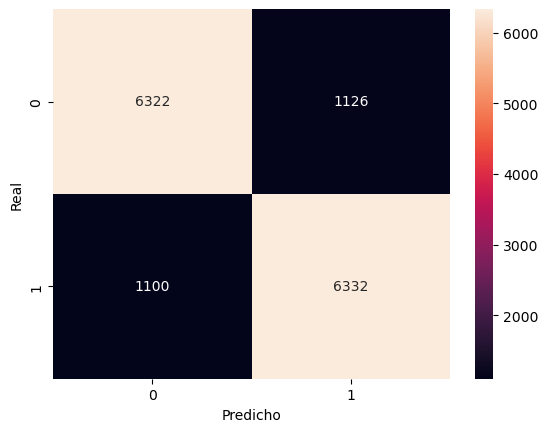

In [ ]:
prediccion_heatmap = np.where(prediccion == 'positivo', 1, 0)

tabla = confusion_matrix(y_test, prediccion_heatmap)
sns.heatmap(tabla, annot=True, fmt='d')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [ ]:
train_sequences = tok.texts_to_sequences(X_train)
train_sequences_matrix = pad_sequences(train_sequences, maxlen=max_len)
prediccion_train = model_rnn.predict(train_sequences_matrix)
prediccion_train = np.where(prediccion_train >= 0.5, 1, 0)
mostrar_scores(y_train, prediccion_train)

   1/1085 [..............................] - ETA: 4:56

2023-11-15 21:23:10.561498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-15 21:23:10.561955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-15 21:23:10.562568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1085/1085 [==============================] - 114s 105ms/step
Accuracy: 0.9131311385696592
Recall: 0.9119399564569726
Precision: 0.9149804552770752
f1 score: 0.9134576757532281


In [ ]:
np.random.seed(1)
tf.random.set_seed(1)
keras.utils.set_random_seed(812)
os.environ['PYTHONHASHSEED']=str(1)

df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})
x_train, x_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)

max_len = 1000
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=128),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x=sequences_matrix, y=y_train, epochs=10)

# model.evaluate(x=x_test, y=y_test)


Epoch 1/10


2023-11-15 22:15:33.883538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-15 22:15:33.884783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-15 22:15:33.885307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1085/1085 [==============================] - 553s 509ms/step - loss: 0.4476 - accuracy: 0.7848
Epoch 2/10
1085/1085 [==============================] - 536s 494ms/step - loss: 0.2515 - accuracy: 0.8988
Epoch 3/10
1085/1085 [==============================] - 531s 489ms/step - loss: 0.1804 - accuracy: 0.9318
Epoch 4/10
1085/1085 [==============================] - 533s 491ms/step - loss: 0.1094 - accuracy: 0.9612
Epoch 5/10
1085/1085 [==============================] - 539s 497ms/step - loss: 0.0599 - accuracy: 0.9803
Epoch 6/10
1085/1085 [==============================] - 553s 509ms/step - loss: 0.0414 - accuracy: 0.9860
Epoch 7/10
1085/1085 [==============================] - 540s 498ms/step - loss: 0.0246 - accuracy: 0.9921
Epoch 8/10
1085/1085 [==============================] - 539s 497ms/step - loss: 0.0200 - accuracy: 0.9933
Epoch 9/10
1085/1085 [==============================] - 536s 494ms/step - loss: 0.0201 - accuracy: 0.9929
Epoch 10/10
1085/1085 [==============================] - 

In [ ]:
test_sequences = tok.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=1000)
prediccion = model.predict(test_sequences_matrix)
prediccion = np.where(prediccion >= 0.5, 1, 0)
mostrar_scores(y_test, prediccion)
prediccion = np.where(prediccion == 1, 'positivo', 'negativo')

465/465 [==============================] - 53s 113ms/step
Accuracy: 0.8436155913978495
Recall: 0.8690796555435952
Precision: 0.8266990912581594
f1 score: 0.8473597900951131


In [ ]:
train_sequences = tok.texts_to_sequences(x_train)
train_sequences_matrix = pad_sequences(train_sequences, maxlen=max_len)
prediccion_train = model.predict(train_sequences_matrix)
prediccion_train = np.where(prediccion_train >= 0.5, 1, 0)
mostrar_scores(y_train, prediccion_train)

2023-11-15 23:53:15.747490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-15 23:53:15.748132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-15 23:53:15.748825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1085/1085 [==============================] - 126s 115ms/step
Accuracy: 0.9976669834960684
Recall: 0.999427065429128
Precision: 0.9959463317156723
f1 score: 0.997683662672653


### Ensamble de modelos

In [ ]:
display(df_preprocesado_copy)

,ID,review_es,sentimiento
0,0,críticos mencionado después ver solo oz episod...,1
1,1,pequeña pequeña producciónla técnica filmación...,1
2,2,pensé manera maravillosa pasar tiempo fin sema...,1
3,3,básicamente familia niño pequeño jake piensa z...,0
4,4,amor tiempo petter mattei película visualmente...,1
...,...,...,...
49995,49995,pensé película hizo buen trabajo derechano tan...,1
49996,49996,mala parcela mal diálogo mala actuación direcc...,0
49997,49997,católica enseñada escuelas primarias parroquia...,0
49998,49998,voy tener desacuerdo comentario anterior lado ...,0


In [ ]:
estimators = [('xgb', modelo_xg_boost), ('lr', modelo_regresion_logistica), ('mnb', modelo_tfidf)]
ensamble = VotingClassifier(estimators=estimators, voting='soft')
ensamble.fit(X_train, y_train)

prediccion = ensamble.predict(X_test)
mostrar_scores(y_test, prediccion)

Accuracy: 0.874260752688172
Recall: 0.8969321851453176
Precision: 0.8578046583451293
f1 score: 0.8769321844372822


In [ ]:
prediccion_train = ensamble.predict(X_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.9159538005126876
Recall: 0.9333677094075856
Precision: 0.902748531530533
f1 score: 0.9178028169014084


#### Prediccion en los datos de test

In [ ]:
df_test = pd.read_csv('test.csv', sep=',')
df_test

,ID,review_es
0,60000,La mayor virtud de esta película es su existen...
1,60001,"No soy un experto cinéfilo, pero pocas veces m..."
2,60002,Si no eres un incondicional del humor estilo T...
3,60003,"No sé qué está pasando, si la gente se deja ll..."
4,60004,"Pero cuando amanece,y me quedo solo,siento en ..."
...,...,...
8594,68594,"Buena no, lo siguiente. Por fin un film serio ..."
8595,68595,"Me esperaba mucho, pero que mucho, más.Guión m..."
8596,68596,"De mal cuerpo como sensación al finalizar, de ..."
8597,68597,Los que han añadido comentarios os lo han dich...


In [ ]:
df_test_copia = df_test.copy()
df_test_copia['review_es'] = df_test_copia['review_es'].apply(preprocess_text)

train_sequences = tok.texts_to_sequences(df_test_copia['review_es'])
train_sequences_matrix = pad_sequences(train_sequences, maxlen=max_len)
prediccion_final = model.predict(train_sequences_matrix)
prediccion_final = np.where(prediccion_final >= 0.5, 1, 0)


prediccion_final = np.where(prediccion_final == 0, 'negativo', 'positivo')


df_entrega = df_test.copy()

df_entrega['sentimiento'] = prediccion_final
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('rnr_conv.csv', index=False)